# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [ ]:
# Downloading the dog and human dataset
from IPython.display import clear_output
!wget -cq -O dogImages.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -cq -O lfw.tgz http://vis-www.cs.umass.edu/lfw/lfw.tgz
clear_output()  
print("Downloaded Successfully")

Downloaded Successfully


In [ ]:
# Extractting the datasets
!unzip -n dogImages.zip
!tar -xvzf lfw.tgz
clear_output()
print("Extracted Successfully")

Extracted Successfully


In [ ]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [ ]:
# Downloading the pre-trained face detector
import os
if not os.path.isdir('haarcascades'):
    os.mkdir('haarcascades')
!wget -cq -O haarcascades/haarcascade_frontalface_alt.xml https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-dog-classification/haarcascades/haarcascade_frontalface_alt.xml
clear_output()
print("Downloaded Successfully")

Downloaded Successfully


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


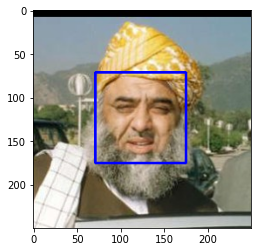

In [ ]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [ ]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)


What percentage of the first 100 images in human_files have a detected human face? 100%
What percentage of the first 100 images in dog_files have a detected human face? 16%

In [ ]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_detections = np.sum([face_detector(img) for img in tqdm(human_files_short)])
dog_detections = np.sum([face_detector(img) for img in tqdm(dog_files_short)])

print('face detection in human image set = {}%'.format(human_detections))
print('face detection in dog image set = {}%'.format(dog_detections))

100%|██████████| 100/100 [00:47<00:00,  2.13it/s]

face detection in human image set = 100%
face detection in dog image set = 16%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [ ]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Is GPU available: ', 'Yes' if torch.cuda.is_available() else 'No')
VGG16 = VGG16.to(device)

Is GPU available:  Yes


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path    
    Args:
        img_path: path to an image        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''   
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    img = Image.open(img_path) # Load the image from provided path
        
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])
    img_tensor = preprocess(img).float()
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis.
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    
    # Now that we have preprocessed our img, we need to convert it into a 
    # Variable; PyTorch models expect inputs to be Variables. A PyTorch Variable is a  
    # wrapper around a PyTorch Tensor.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable    
    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())
        
    VGG16.eval()
    output = VGG16(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    #Variable has a .data attribute. This is a torch Tensor, which has a .numpy() method, 
    #which gives us a numpy array. We can call .argmax() on the numpy array to get the index of the maximum element. 
    #This is the predicted class. We find the value with that key from labels and we get our class label
    predict_index = output.data.numpy().argmax() # Our prediction will be the index of the class label with the largest value.
    return predict_index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    return ((prediction <= 268) & (prediction >= 151)) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- dog detection in human image set = 0%
- dog detection in dog image set = 100%



In [ ]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
from tqdm import tqdm

human_detections = np.sum([dog_detector(img) for img in tqdm(human_files_short)])
dog_detections = np.sum([dog_detector(img) for img in tqdm(dog_files_short)])

print('dog detection in human image set = {}%'.format(human_detections))
print('dog detection in dog image set = {}%'.format(dog_detections))

100%|██████████| 100/100 [00:02<00:00, 47.37it/s]

dog detection in human image set = 0%
dog detection in dog image set = 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [ ]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transforms = {
    'train': transforms.Compose([
#        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}

# Specifying the directores
data_dir = 'dogImages'
train = data_dir + '/train'
valid = data_dir + '/valid'
test = data_dir + '/test'
batch_size = 20
num_workers = 0
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}
    
loaders_data = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size,
                                              shuffle = True, num_workers = num_workers)
                  for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
n_classes = len(class_names)
  

# print statistics about the dataset
print(f"No. of Training Records: {dataset_sizes['train']}")
print(f"No. of Validation Records: {dataset_sizes['valid']}")
print(f"No. of Testing Records: {dataset_sizes['test']}")      
print(f"No. of Classes: {n_classes}")
      
#Check if gpu support is available
use_cuda = torch.cuda.is_available()


No. of Training Records: 6680
No. of Validation Records: 835
No. of Testing Records: 836
No. of Classes: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

- All images are resized and used all color channel to 224x224x3 and normalized. All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
- Only training images receive further augmentation by flipping the images horizontally and 10 degree of rotation. These augmentations should help our model generalize and reduce overfitting. Overfitting is a general problem in our experiment. Some methods used to preprocessing our data to improve the effect of model training and alleviate the effect of overfitting are:
- Crop: Random Cropping is a common method in augmentation, which is to randomly sample a section from the original image and resize it to its original image size. In our experiment, we randomly extract a 224 × 224 pixels section from 256 × 256 pixels.
- Flip: Each image can be flipped horizontally and vertically. In our task, images are just flipped horizontally.
Rotation: Each image can be rotate. In our task, images are roated 10 degree.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1 )        
        # convolutional layer (sees 112x112x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # convolutional layer (sees 56x56x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # convolutional layer (sees 28x28x64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)        
        # convolutional layer (sees 14x14x128 image tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1 )
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # linear layer (256 * 7 * 7 -> 512)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (256 * 7 * 7 -> n_classes (133))
        self.fc2 = nn.Linear(512, n_classes)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv_bn6(x)
        
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)        
        # add dropout layer
        x = self.dropout(x)
        # add second hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print (model_scratch)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- When defining my architecture I was inspired by the VGG16 architecture as I decided to reproduce the first block of the architecture with the same number of convoultional layers with kernel sizes of 3x3 and padding of 1 followed by a maxpooling layer that reduce the size of the feature maps by 2. My architecture consists of 3 of these blocks with deeper depth sizes (number of filters). But, I introduced my own tweek to each block by adding a batch normalization layer after every convolutional layer, that will help normalize it.

- After block 3, I used one convolutional layer , a batchnorm layer and a relu activation function , followed by and adaptative average max pooling layer that is inspired from the Fastai library which concatinates the outputs of an adaptative max pooling and an adaptative average pooling layers applied to the same ouput of the previously defined layers( relu(batchnorm) in this case). This help take adavanteg of both of the adaptaive max and average pooling layers rather then just using a maxpooling or average pooling layer before the fully-connected layers that most state of the art architectures use.

- The ouput of the adaptativeaveragemaxpooling layer is flattened to be fed to a classifier of two fully-connected layers. This classifer is also a reimplementation in Pytorch of the default classifer used by Fastai that is proved to give better results. Two dropout layers are added to prevent overfitting.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [ ]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [ ]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

n_epochs = 25
loaders_scratch = loaders_data
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch,
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.708502 	Validation Loss: 4.370644
Validation loss decreased (inf --> 4.370644).  Saving model ...
Epoch: 2 	Training Loss: 4.430423 	Validation Loss: 4.180336
Validation loss decreased (4.370644 --> 4.180336).  Saving model ...
Epoch: 3 	Training Loss: 4.256246 	Validation Loss: 4.027716
Validation loss decreased (4.180336 --> 4.027716).  Saving model ...
Epoch: 4 	Training Loss: 4.122229 	Validation Loss: 3.930874
Validation loss decreased (4.027716 --> 3.930874).  Saving model ...
Epoch: 5 	Training Loss: 4.019715 	Validation Loss: 3.829722
Validation loss decreased (3.930874 --> 3.829722).  Saving model ...
Epoch: 6 	Training Loss: 3.917372 	Validation Loss: 3.867317
Epoch: 7 	Training Loss: 3.811991 	Validation Loss: 3.661947
Validation loss decreased (3.829722 --> 3.661947).  Saving model ...
Epoch: 8 	Training Loss: 3.746490 	Validation Loss: 3.602766
Validation loss decreased (3.661947 --> 3.602766).  Saving model ...
Epoch: 9 	Training Loss: 3.670948 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.059466


Test Accuracy: 26% (222/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.densenet161(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False
num_ftrs = model_transfer.classifier.in_features
model_transfer.classifier = nn.Linear(num_ftrs, n_classes)

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Transfer learning involves taking a pre-trained neural network and adapting the neural network to a new, different data set. Depending on the size of the new data set, and the similarity of the new data set to the original data set.

Since our data set is small CONVNET AS FIXED FEATURE EXTRACTOR method are used ( https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html):

slice off the end of the neural network
freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().
add a new fully connected layer that matches the number of classes in the new data set
randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
train the network to update the weights of the new fully connected layer
In our task, we need to classify 133 breeds of dogs from only approximatly 6600 images. We do not have sufficient training data to train a new and complex model that can perform well on testing dataset. Thus, we directly download different models ,such as ResNet18, VGG16, and DenseNet161 from Pytorch which we use as our framework. But the weights on the last layer of each model are exactly random and the number of categories in outputs of each model is different from 133 that we need. In order to fix it, we freeze all layer but the last. Freezing is to make the layer weights invariant during training. We also add one fully connected layers to replace the last layer of each pre-trained model.

After viewing the test accuracy for different models and reading this paper http://noiselab.ucsd.edu/ECE228/Reports/Report18.pdf , I decided to select DenseNet161 model. This model has performed well on a similar dataset. I also checked vgg16 and resnet18 models.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001, momentum=0.9)
#optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
n_epochs = 25
loaders_transfer = loaders_data
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.075673 	Validation Loss: 2.889394
Validation loss decreased (inf --> 2.889394).  Saving model ...
Epoch: 2 	Training Loss: 2.690328 	Validation Loss: 1.791675
Validation loss decreased (2.889394 --> 1.791675).  Saving model ...
Epoch: 3 	Training Loss: 2.011156 	Validation Loss: 1.290246
Validation loss decreased (1.791675 --> 1.290246).  Saving model ...
Epoch: 4 	Training Loss: 1.606652 	Validation Loss: 0.987345
Validation loss decreased (1.290246 --> 0.987345).  Saving model ...
Epoch: 5 	Training Loss: 1.424363 	Validation Loss: 0.831911
Validation loss decreased (0.987345 --> 0.831911).  Saving model ...
Epoch: 6 	Training Loss: 1.272390 	Validation Loss: 0.737039
Validation loss decreased (0.831911 --> 0.737039).  Saving model ...
Epoch: 7 	Training Loss: 1.178463 	Validation Loss: 0.661970
Validation loss decreased (0.737039 --> 0.661970).  Saving model ...
Epoch: 8 	Training Loss: 1.106795 	Validation Loss: 0.611166
Validation loss decreased (0.66197

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.376953


Test Accuracy: 88% (742/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import matplotlib.image as mpimg

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    
    # load the image and return the predicted breed    
    img = Image.open(img_path) # Load the image from provided path
    
    # Now that we have an img, we need to preprocess it.
    # We need to:
    #       * resize the img.
    #       * normalize it, as noted in the PyTorch pretrained models doc,
    #         with, mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
    #       * convert it to a PyTorch Tensor.
    #
    # We can do all this preprocessing using a preprocess.
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])
    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable
    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())        
    model_transfer.eval()
    output = model_transfer(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    predict_index = output.data.numpy().argmax() # Our prediction will be the index of the class label with the largest value.
    return predict_index, class_names[predict_index], image_datasets['train'].classes[predict_index]

In [ ]:
### Display prediction
def display_predictions(img_path):
    #print (img_path)
    pred_index, breed, name = predict_breed_transfer(img_path)
    print("Hey DOG... What's up?!")
        
    # display test image
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(1,2,1)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    plt.axis('off')

    # display sample of matching breed images
    subdir = '/'.join(['/data/dog_images/valid', str(name)])
    file = random.choice(os.listdir(subdir))
    path = '/'.join([subdir, file])
    ax = fig.add_subplot(1,2,2)
    img = mpimg.imread(path)
    ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
    plt.title(breed)
    plt.axis('off')
    plt.show()   
    
    # extract breed from image path
    actual_breed = img_path.split('/')[4].split('.')[1]
    print(f"Actual Breed: {actual_breed}\n")
    print(f"Predicted Breed: {breed}\n")
    print("\n"*3)

In [ ]:
# Create list of test image paths
test_img_paths = sorted(glob('/data/dog_images/test/*/*'))
# Shuffle the list and display first few rows
np.random.shuffle(test_img_paths)
test_img_paths[1:5]

for img_path in test_img_paths[0:5]:
    display_predictions(img_path)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    '''
    Use pre-trained model to to check if the image at the given path
    contains a human being or a dog or none. 
    
    Args:
        img_path: path to an image
        
    Returns:
        print if a human face is detected or not
        print the dog breed or show that neither human face nor a dog detected 
    '''       
    data_dir = 'dogImages'
    train = data_dir + '/train'
    valid = data_dir + '/valid'
    test = data_dir + '/test'     
    is_human = face_detector(img_path)
    is_dog = dog_detector(img_path)
    pred_index, breed, name = predict_breed_transfer(img_path)
        
    # display test image
    fig = plt.figure(figsize=(16,4))
    
    if(is_human):
        print("Hey... What's up HUMAN?!")
        ax = fig.add_subplot(1,2,1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        plt.axis('off')

        # display sample of matching breed images
        subdir = '/'.join([valid, str(name)])
        file = random.choice(os.listdir(subdir))
        path = '/'.join([subdir, file])
        ax = fig.add_subplot(1,2,2)
        img = mpimg.imread(path)
        ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
        plt.title(breed)
        plt.axis('off')
        plt.show()   
        print("You look like ..." + breed)
        print("\n"*3)
        return
    
    elif(is_dog):
        print("Hey... What's up DOG?!")
        ax = fig.add_subplot(1,2,1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        plt.axis('off')

        # display sample of matching breed images
        subdir = '/'.join([valid, str(name)])
        file = random.choice(os.listdir(subdir))
        path = '/'.join([subdir, file])
        ax = fig.add_subplot(1,2,2)
        img = mpimg.imread(path)
        ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
        plt.title(breed)
        plt.axis('off')
        plt.show()   
        print("You look like ... " + breed)
        print("\n"*3)
        return
    
    else:
        print('Error!... I can not determine what you are!')
        ax = fig.add_subplot(1,2,1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        plt.axis('off')
        plt.show()    
        print("\n"*3)
        return

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The acheived test accuracy of my algorithm is 88% that is excellent. Algorithm works well in detecting if pictures contain a human face or a dog. The results from running my algorithm on the files in the 'human_files' and 'dog_files' directory are excellent. All of the dog breeds appear to be correctly classified, or at least very good guesses. The output of my images in 'test_images' directory are excelent as unexpected. It is not misclassifed the cat images as a dog!!
Some possible points of improvement:
data augmentation to have a better model generalizer such as flipping, rotation, cropping, position shifts, color channel shifts, ...
improve the data train set
select the best optimizer
select the best learning rate

Hey... What's up HUMAN?!


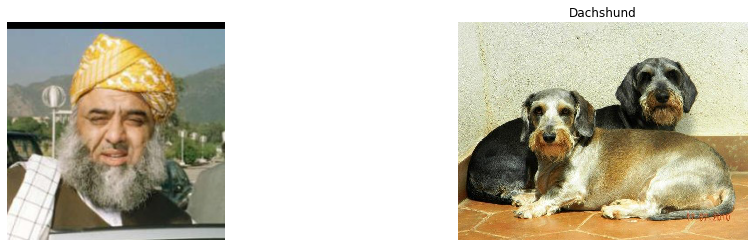

You look like ...Dachshund




Hey... What's up HUMAN?!


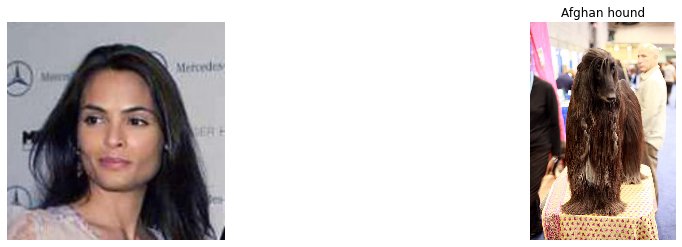

You look like ...Afghan hound




Hey... What's up HUMAN?!


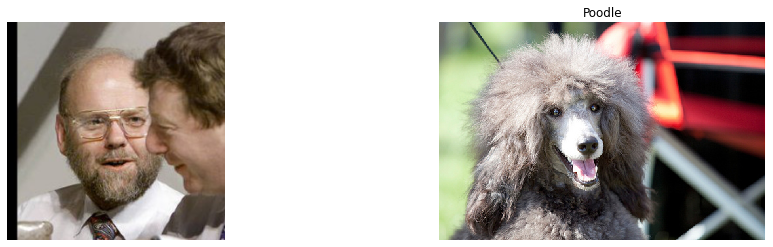

You look like ...Poodle




Hey... What's up DOG?!


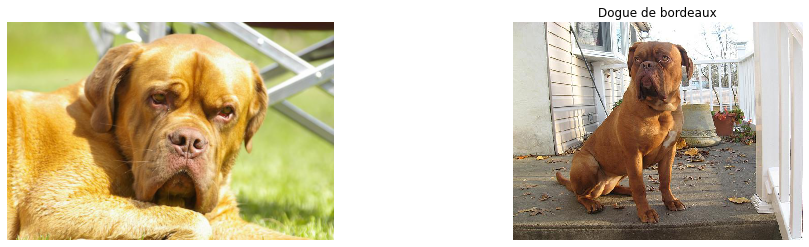

You look like ... Dogue de bordeaux




Hey... What's up DOG?!


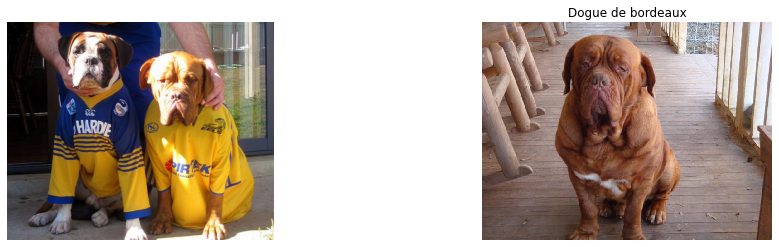

You look like ... Dogue de bordeaux




Hey... What's up DOG?!


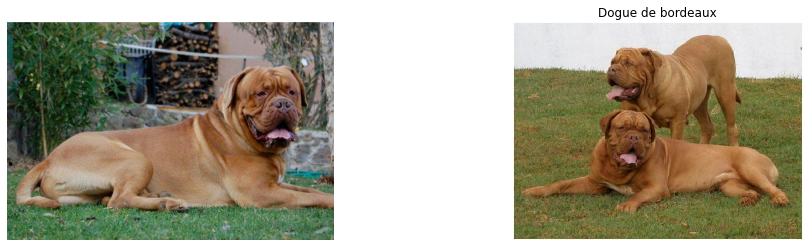

You look like ... Dogue de bordeaux






In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import random

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)